In [75]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.io as sio
import sys
sys.path.append('../helpers')
import loadmat as lm
from sklearn import linear_model
from scipy import signal
from sklearn.model_selection import cross_val_score, cross_validate

In [89]:
cl_data = lm.loadmat(r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npI1_0418_mismatch_4.mat')

In [84]:
ol_data = lm.loadmat(r'Z:\giocomo\attialex\NP_DATA\CL_OL_Towers\npI1_0418_playback_4.mat')

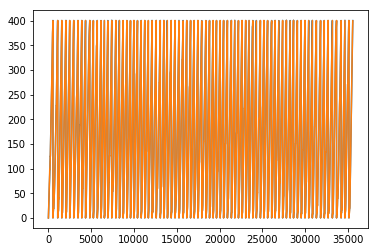

In [68]:
plt.plot(cl_data['posx'])
plt.plot(ol_data['posx'])

In [90]:
track_start = 0
track_end = 400
posx=cl_data['posx']
post=cl_data['post']
trial = cl_data['trial']
sp = cl_data['sp']
dx=5
dt=0.2
every_nth_time_bin = 10
numposbins = np.floor((track_end-track_start)/dx)
posx_edges = np.linspace(track_start,track_end,numposbins+1)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


In [91]:


# resample post, posx, and trial according to desired dt
post = post[0::every_nth_time_bin]
posx = posx[0::every_nth_time_bin]
trial = trial[0::every_nth_time_bin]

# get cell ids of "good" units
good_cells = sp['cids'][sp['cgs']==2]

# time bins for position decoding
numtimebins = len(post)
post_edges = np.squeeze(np.linspace(min(post)-dt/2,max(post)+dt/2,numtimebins+1))
post_centers = post_edges[range(0,len(post_edges)-1)]+dt/2

# posx categories for position decoding (binned)
posx_bin = np.digitize(posx,posx_edges)

# count spikes in each time bin for each cell
spikecount = np.empty((len(good_cells),len(post),))
spikecount[:] = np.nan
for cell_idx in range(len(good_cells)):   
    spike_t = sp['st'][sp['clu']==good_cells[cell_idx]]
    spikecount[cell_idx,:] = np.histogram(spike_t,bins=post_edges)[0]

In [71]:
train_set = np.squeeze(trial<=30)
X_train = np.transpose(spikecount[:,train_set])
y_train = np.squeeze(posx_bin[train_set])
model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1).fit(X_train, y_train) 

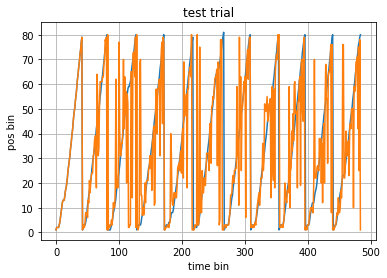

In [72]:
test_set = np.squeeze(np.logical_and(trial>=30,trial <=40))
X_test = np.transpose(spikecount[:,test_set])
y_test = np.squeeze(posx_bin[test_set])
y_pred = model.predict(X_test)

fig, ax = plt.subplots()
ax.plot(range(len(y_test)),y_test)
ax.plot(range(len(y_pred)),y_pred)

ax.set(xlabel='time bin', ylabel='pos bin', title='test trial')
ax.grid()
plt.show()

In [73]:
model.score(X_test,y_test)

0.23760330578512398

In [ ]:
def custom_score(y, y_pred, **kwargs):
    return np.mean(np.sqrt((y-y_pred)**2))

In [80]:
from sklearn.metrics import make_scorer
>>> scoring = {'prec_macro': 'precision_macro','custom_macro': make_scorer(custom_score)}
model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1)
#scores = cross_val_score(model, , cv=5)
scores = cross_validate(model,np.transpose(spikecount), posx_bin,scoring=scoring, cv=5,return_estimator=True)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\attialex\AppData\Local\Continuum\anaconda3\envs\panda3d\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defin

In [81]:
scores

{'fit_time': array([113.68945193, 114.09383106,  36.8607657 ,  28.93953371,
         40.31939459]),
 'score_time': array([0.00398922, 0.00299239, 0.00299335, 0.00299335, 0.00299287]),
 'estimator': (LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=10000,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False),
  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=10000,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False),
  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling

In [47]:
scores

array([0.19086022, 0.19917582, 0.21097046, 0.19856115, 0.20088626])

In [48]:
model

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
model = linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000, C = 0.1).fit(np.transpose(spikecount), posx_bin) 


In [93]:
custom_score(model.predict(np.transpose(spikecount)),posx_bin)

0.0005625879043600563

In [105]:
model.score(np.transpose(spikecount),np.roll(posx_bin,0))

0.99943741209564

In [112]:
ol_posx=ol_data['posx']
ol_post=ol_data['post']
ol_trial = ol_data['trial']
ol_sp = ol_data['sp']
# resample post, posx, and trial according to desired dt
ol_post = ol_post[0::every_nth_time_bin]
ol_posx = ol_posx[0::every_nth_time_bin]
ol_trial = ol_trial[0::every_nth_time_bin]

# get cell ids of "good" units
good_cells = ol_sp['cids'][ol_sp['cgs']==2]

# time bins for position decoding
numtimebins = len(ol_post)
post_edges = np.squeeze(np.linspace(min(ol_post)-dt/2,max(ol_post)+dt/2,numtimebins+1))
post_centers = post_edges[range(0,len(post_edges)-1)]+dt/2

# posx categories for position decoding (binned)
ol_posx_bin = np.digitize(ol_posx,posx_edges)

# count spikes in each time bin for each cell
ol_spikecount = np.empty((len(good_cells),len(ol_post),))
ol_spikecount[:] = np.nan
for cell_idx in range(len(good_cells)):   
    spike_t = ol_sp['st'][ol_sp['clu']==good_cells[cell_idx]]
    ol_spikecount[cell_idx,:] = np.histogram(spike_t,bins=post_edges)[0]



In [113]:
model.score(np.transpose(ol_spikecount),np.roll(ol_posx_bin,1))

0.14004499437570303

In [114]:
custom_score(model.predict(np.transpose(ol_spikecount)),ol_posx_bin)

8.509842519685039

In [63]:
yhat = model.predict(np.transpose(spikecount))
custom_score(posx_bin,yhat)

8.509842519685039